In [47]:

# standard imports
import os
import time

# local imports
from train_gan_vanilla_model import train_model
from gan_vanilla_model import generator, discriminator


# third party imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import *
import numpy as np
import matplotlib.pyplot as plt


In [48]:
# helper function

def save_evolution_of_generator(G, num_epoch, num_samples, save_dir, device):
    """ Saves the images generated by the generator during training """
    
    noise = (torch.rand(16, 128)-0.5)/0.5
    noise = noise.to(device)
    fake_inputs = G(noise)
    fake_inputs = fake_inputs.cpu().detach().numpy()
    fake_inputs = np.reshape(fake_inputs, [16, 28, 28])
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(fake_inputs[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'epoch_{}.png'.format(num_epoch)))

In [54]:
device = torch.device("mps") # change this depending on your local machine

"""
Hyperparameter settings
"""
epochs = 150
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()

# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


In [55]:
"""
Image transformation and dataloader creation
Note that we are training generation and not classification, and hence
only the train_loader is loaded
The train_loader is a dataloader object that loads the MNIST dataset
    - The MNIST dataset is a dataset of handwritten digits
    - The dataset is loaded from the torchvision.datasets package
    - The dataset is loaded as a pytorch tensor
"""
# Transform
transform =  Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])
# Load data
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

Files already downloaded


In [ ]:
%time
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward( retain_graph=True)
        D_optimizer.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))
            # show images evolutions
            save_evolution_of_generator(G, epoch, idx, './data/images', device)
            # show images generated by the generator
            # early stoppping


    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

In [64]:
def generate( num_samples, device, model):
    """ Generates images using the generator """
    noise = (torch.rand(num_samples, 128)-0.5)/0.5
    noise = noise.to(device)
    fake_inputs = G(noise)
    fake_inputs = fake_inputs.cpu().detach().numpy()
    fake_inputs = np.reshape(fake_inputs, [num_samples, 28, 28])
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(fake_inputs[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

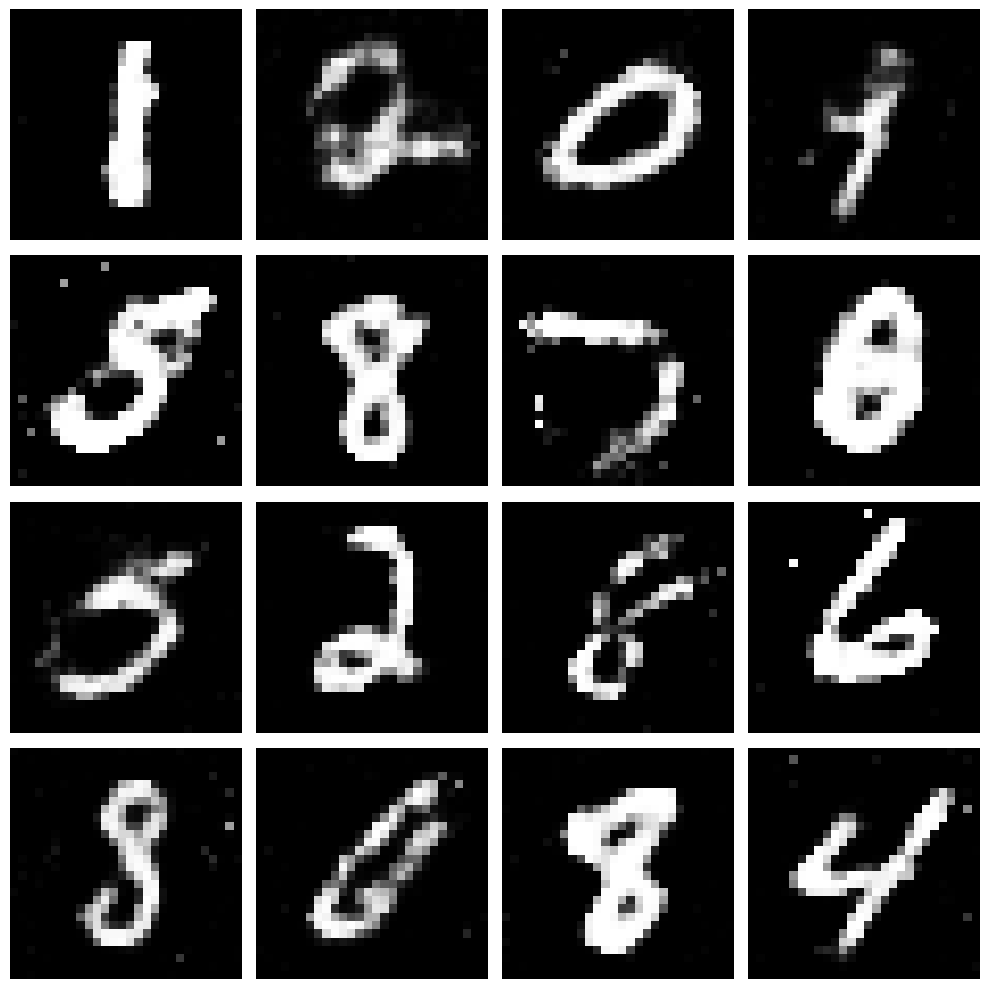

In [65]:
# run inference
# load the model
G = torch.load('Generator_epoch_49.pth')
generate(16, device, G)

/var/folders/_h/2c517whn70d0cdkhh9th6z740000gn/T/ipykernel_21751/1246646570.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


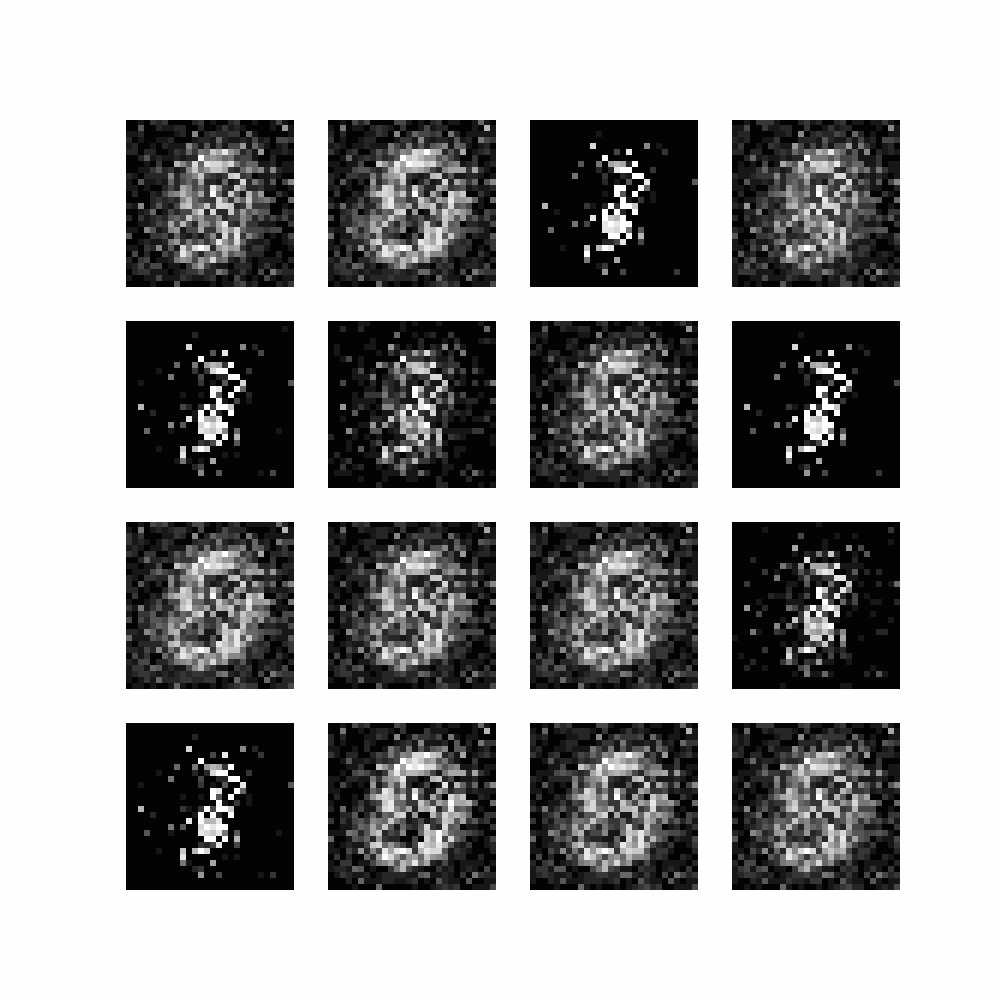

In [45]:
# iterate through the images and create an interactive gif 

import imageio
import glob
from IPython.display import Image

import os
import imageio

png_dir = './data/images/'
images = []
for ex in range():
    file_path = os.path.join(png_dir, 'epoch_{}.png'.format(ex))
    if file_path.endswith(".png"):
        images.append(imageio.imread(file_path))


imageio.mimsave('evolution.gif', images, duration=0.5)

Image(open('evolution.gif','rb').read())
